# Augmented Embeddings using Neural Network

## Load images

In [2]:
import PIL
import numpy as np
import matplotlib.pyplot as plt

def load_images():
    """Load images from the folder"""
    images = []
    for i in range(4):
        img = PIL.Image.open('./data/images/' + str(i + 1) + '.png')
        img = np.array(img)
        images.append(img)
    return images

images = load_images()

TOTAL_IMAGES = len(images)

ORIGINAL_IMAGE_SIZE = images[0].shape[0] # 1024
EMBEDDING_IMAGE_SIZE = 224

Visualise images

(1024, 1024, 3)

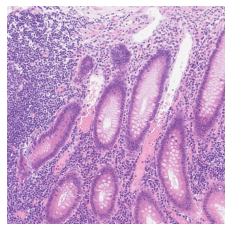

In [3]:
image = images[0]
# plt.imshow(image.rotate(0.5))
plt.axis('off')
plt.imshow(image)
image.shape

## Augmentation

Perform augmentations on images

In [4]:
import albumentations as A

def perform_augmentation(image, augmentation):
    """Perform given augmentation on image and crop to appropriate size for ResNet 50"""

    transform = A.Compose([
        augmentation,
        A.CenterCrop(height=EMBEDDING_IMAGE_SIZE, width=EMBEDDING_IMAGE_SIZE),
    ])

    transformed_image = transform(image=image)['image']
    return transformed_image

def aug_rot(image, angle):
    """Augment image with rotation (int from 0 to 360)"""

    augmentation_rotate = A.Rotate((angle, angle), always_apply=True)
    return perform_augmentation(image, augmentation_rotate)

def aug_colour_jitter(image, hue, sat, val):
    """Colour jitter"""

    augmentation_jitter = A.HueSaturationValue(
        hue_shift_limit=(hue, hue),
        sat_shift_limit=(sat, sat),
        val_shift_limit=(val, val),
        always_apply=True
    )
    return perform_augmentation(image, augmentation_jitter)

def aug_hue(image, hue):
    """Augment image with hue (int from -100 to 100)"""

    return aug_colour_jitter(image, hue, 0, 0)

def aug_sat(image, sat):
    """Augment image with sat (int from -100 to 100)"""

    return aug_colour_jitter(image, 0, sat, 0)

def aug_val(image, val):
    """Augment image with val (int from -100 to 100)"""

    return aug_colour_jitter(image, 0, 0, val)

def aug_zoom(image, zoom):
    """Augment image with zoom (float from 0 to 100)"""

    size = int(ORIGINAL_IMAGE_SIZE * (1 + zoom / 100))
    augmentation_zoom = A.Resize(height=size, width=size, always_apply=True)
    return perform_augmentation(image, augmentation_zoom)

def aug_noise(image, noise):
    """Augment image with noise (float from 0 to 500)"""

    augmentation_noise = A.GaussNoise(var_limit=(noise, noise), always_apply=True)
    return perform_augmentation(image, augmentation_noise)


Visualise augmented images

(224, 224, 3)

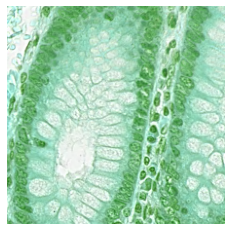

In [5]:
# transformed_image = aug_rot(image=image, angle=20)
transformed_image = aug_hue(image=image, hue=100)
# transformed_image = aug_zoom(image=image, zoom=50)
plt.axis('off')
plt.imshow(transformed_image)
transformed_image.shape

Convert PIL images into Pytorch tensors

In [6]:
from torchvision import transforms as transform_lib

def convert_to_tensor(image):
    t = transform_lib.Compose([
        transform_lib.ToTensor(),
        transform_lib.CenterCrop(EMBEDDING_IMAGE_SIZE),
        transform_lib.Normalize(
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
        )
    ])

    image_tensor =  t(image)
    return image_tensor

Generate augmentation images for specified image and aug type

In [7]:
def generate_aug_images(image, aug, z):
    aug_images = []
    for value in z:
        aug_image = aug(image, value)
        aug_image_tensor = convert_to_tensor(aug_image)
        aug_images.append(aug_image_tensor)
    return aug_images

## Retrieve embeddings

Modified ResNet 50 model

In [8]:
# modified from Pytorch official resnet.py
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch
from torchsummary import summary
import torch.nn.functional as F

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

class Bottleneck_Baseline(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck_Baseline, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet_Baseline(nn.Module):

    def __init__(self, block, layers):
        self.inplanes = 64
        super(ResNet_Baseline, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1) 

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

def resnet50_baseline(pretrained=False):
    """Constructs a Modified ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet_Baseline(Bottleneck_Baseline, [3, 4, 6, 3])
    if pretrained:
        model = load_pretrained_weights(model, 'resnet50')
    return model

def load_pretrained_weights(model, name):
    pretrained_dict = model_zoo.load_url(model_urls[name])
    model.load_state_dict(pretrained_dict, strict=False)
    return model

Feed augmented images to ResNet 50 and save embeddings

In [9]:
model = resnet50_baseline(pretrained=True)

# only using one image for now
def get_embeddings(aug_images, batch_size=4):
    embeddings = {}
    # print(len(aug_images))
    runs = len(aug_images) // batch_size

    for i in range(runs):
        # print("Running batch {}/{}".format(i + 1, runs))
        batch = aug_images[i * batch_size : (i + 1) * batch_size]
        input = torch.stack(batch, dim=0)
        # print(input.shape)
        # input = input.cuda()

        output = model(input)
        output = output.cpu().detach().numpy()
        # print(output.shape)
        # output_list = output.tolist()
        for j in range(len(output)):
            # print(output[j].shape)
            embeddings[i * batch_size + j] = output[j]
        # print(len(embeddings[i]))
    return embeddings

## Experiment

Augmentation info stored in the `aug_info` dictionary

In [10]:
aug_info = [
    { "key": "aug_rot", "aug_function": aug_rot, "title": "rotation", "z": np.arange(0, 360, 1) },
    # { "key": "aug_hue", "aug_function": aug_hue, "title": "hue shift", "z": np.arange(-100, 100) },
    # { "key": "aug_sat", "aug_function": aug_sat, "title": "saturation shift", "z": np.arange(-100, 100, 1) },
    # { "key": "aug_val", "aug_function": aug_val, "title": "value shift", "z": np.arange(-100, 100, 1) },
    # { "key": "aug_zoom", "aug_function": aug_zoom, "title": "zoom in", "z": np.linspace(-15, 15, 100) },
    # {"key": "aug_noise", "aug_function": aug_noise, "title": "gaussian noise", "z": np.linspace(0, 100, 100) }
]

Data info will be stored in the `data` dictionary

In [11]:
data = {}
for i in range(TOTAL_IMAGES):
    data[i + 1] = {}

Gather data

In [12]:
for aug in aug_info:
    for i in range(1, TOTAL_IMAGES + 1):
        print(f"{aug['title']} - {i}/{TOTAL_IMAGES}")

        # augmentation
        aug_images = generate_aug_images(images[i - 1], aug["aug_function"], aug["z"])
        data[i][aug["key"]] = aug_images
        
        # embeddings
        embeddings = get_embeddings(aug_images, batch_size=4)
        data[i]["embeddings_" + aug["key"]] = embeddings

        data[i]["original_embedding_" + aug["key"]] = embeddings[0]

        # reduce dimensions
        # data[i]["reduced_" + aug["key"]] = reduce_dims(dims=2, embeddings=embeddings, method=DIM_REDUCTION_METHOD)

rotation - 1/4
rotation - 2/4
rotation - 3/4
rotation - 4/4


In [13]:

def gen_inputs():
    X = torch.empty(360 * 4, 1025)
    for aug in aug_info:
        z = aug['z']
        z_normalised = (z - np. min(z)) / (np. max(z) - np. min(z))
        for i in range(1, TOTAL_IMAGES + 1):
            for j, z_norm in enumerate(z_normalised):
                x = np.append(data[i]['original_embedding_' + aug['key']], z_norm)
                x = torch.from_numpy(x)
                X[(i - 1) * j + j] = x
    return X

def gen_outputs():
    Y = torch.FloatTensor()
    for aug in aug_info:
        for i in range(1, TOTAL_IMAGES + 1):
            e = list(data[i]["embeddings_" + aug["key"]].values())
            embeddings = torch.FloatTensor(e)
            Y = torch.cat((Y, embeddings), dim=0)
    return Y

X = gen_inputs()
Y = gen_outputs()

print(X.shape)
print(Y.shape)


torch.Size([1440, 1025])
torch.Size([1440, 1024])


/var/folders/r_/tvf32fg16913mf2n9m54hkxw0000gn/T/ipykernel_42049/3264044998.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  embeddings = torch.FloatTensor(e)


## Neural network

Model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

class NeuralNetwork(nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1025, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


net = NeuralNetwork()
print(net)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1025, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
  )
)


Split data into train and test

In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

def next_batch(inputs, targets, batch_size):
	# loop over the dataset
	for i in range(0, inputs.shape[0], batch_size):
		# yield a tuple of the current batched data and labels
		yield i, (inputs[i:i + batch_size], targets[i:i + batch_size])

Train model

In [16]:
from torch.autograd import Variable

def train_loop(trainX, trainY, batch_size, model, loss_fn, optimizer):
    size = trainX.shape[0]
    for batch, (X, y) in next_batch(trainX, trainY, batch_size):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y, torch.ones(size))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(X):>5d}]")


def test_loop(testX, testY, batch_size, model, loss_fn):
    size = testX.shape[0]
    num_batches = size / batch_size
    test_loss, correct = 0, 0

    with torch.no_grad():
        for _, (X, y) in next_batch(testX, testY, batch_size):
            pred = model(X)
            test_loss += loss_fn(pred, y, torch.ones(size)).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

Run model

In [17]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

loss_fn = nn.CosineSimilarity()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(X_train, y_train, batch_size, net, loss_fn, optimizer)
    test_loop(X_test, y_test, batch_size, net, loss_fn)
print("Done!")

Epoch 1
-------------------------------


TypeError: forward() takes 3 positional arguments but 4 were given